In [1]:
import numpy as np
import os
import time
import random
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn.init as init
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchmetrics.classification import MulticlassF1Score
from load_data import ECGDataset, ECGCollate, SmartBatchSampler, load_dataset, load_ecg
from resnet1d import ResNet1D
from mask import Mask
from plot_utils import plot_lth_progress, plot_layerwise_remaining_params
from save_utils import save_checkpoint, load_checkpoint, push_checkpoint_to_git

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.


2026-01-11 09:24:22.266109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/python/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)


def train_model(model, train_loader, val_loader, loss_func, tb_logger, prior, epochs=10, name="default"):
    """
    Train the classifier for a number of epochs.
    """
    loss_cutoff = len(train_loader) // 10
    optimizer = torch.optim.Adam(model.parameters(), 0.001)

    # Configuration du F1-Score pour 4 classes (N, A, O, ~)
    # On utilise 'macro' pour donner autant d'importance à chaque classe
    f1_metric = MulticlassF1Score(num_classes=4, average=None).to(device)
    best_f1_val = 0.0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            mode='min', 
                                                            factor=0.1, # like in Hannun et al.
                                                            patience=2 # 2 in Hannun et al. "two consecutive epochs"
                                                            )
                                                    
    for epoch in range(epochs):

        # Training stage, where we want to update the parameters.
        model.train()  # Set the model to training mode

        training_loss = []
        validation_loss = []
        f1_metric.reset()

        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        for train_iteration, batch in training_loop:
            optimizer.zero_grad() 
            ecgs, labels = batch 
            ecgs, labels = ecgs.to(device), labels.to(device)

            pred = model(ecgs) # Stage 1: Forward().
            loss = loss_func(pred, labels) # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step() # Stage 3: Update the parameters.
            # scheduler.step() # Update the learning rate.
            # --- LOGIQUE DE PRÉDICTION (Inspirée de votre snippet) ---
            with torch.no_grad():
                # 1. Softmax + Ajustement par Prior : p / prior
                # On transpose pour avoir les classes en dernière dimension : (B, S, C)
                 # Sortie probable: (Batch, Classes, Time)
                
                probs = F.softmax(pred, dim=1).transpose(1, 2)
                adjusted_probs = probs / prior
                
                # 2. Argmax pour obtenir les indices de classes : (B, S)
                indices = torch.argmax(adjusted_probs, dim=2)
                
                # 3. Réduction temporelle par le MODE : (B,)
                final_preds, _ = torch.mode(indices, dim=1)
                
                # 4. Réduction des labels (Batch, Séquence) -> (Batch,)
                final_labels = labels[:, 0] if labels.dim() > 1 else labels
                
                # Mise à jour de la métrique (Tenseurs 1D d'entiers)
                f1_metric.update(final_preds, final_labels)

            training_loss.append(loss.item())
            training_loss = training_loss[-loss_cutoff:]
            # Calcul du CINC Average partiel pour la barre de progression
            current_f1s = f1_metric.compute()
            current_cinc = torch.mean(current_f1s[:3]).item() # Moyenne A, N, O

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(np.mean(training_loss)),
                                      curr_train_f1=f"{current_cinc:.4f}",
                                      lr = "{:.8f}".format(optimizer.param_groups[0]['lr'])
                                      )

            # Update the tensorboard logger.
            #tb_logger.add_scalar(f'classifier_{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)

        # Validation
        model.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
        f1_metric.reset() # Reset pour calculer uniquement la val
        
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                ecgs, labels = batch
                ecgs, labels = ecgs.to(device), labels.to(device)

                pred = model(ecgs) # Sortie probable: (Batch, Classes, Time)
                
                loss = loss_func(pred, labels)
                validation_loss.append(loss.item())

                probs = F.softmax(pred, dim=1).transpose(1, 2)
                adjusted_probs = probs / prior
                
                # 2. Argmax pour obtenir les indices de classes : (B, S)
                indices = torch.argmax(adjusted_probs, dim=2)
                
                # 3. Réduction temporelle par le MODE : (B,)
                final_preds, _ = torch.mode(indices, dim=1)
                
                # 4. Réduction des labels (Batch, Séquence) -> (Batch,)
                final_labels = labels[:, 0] if labels.dim() > 1 else labels
                
                # Mise à jour de la métrique (Tenseurs 1D d'entiers)
                f1_metric.update(final_preds, final_labels)

                # Calcul du CINC Average partiel pour la barre de progression
                current_val_f1s = f1_metric.compute()
                current_val_cinc = torch.mean(current_val_f1s[:3]).item() # Moyenne A, N, O
                # Update the progress bar.
                val_loop.set_postfix(
                    val_loss = "{:.8f}".format(np.mean(validation_loss)),
                    f1_val=f"{current_val_cinc:.4f}")

                # Update the tensorboard logger.
                #tb_logger.add_scalar(f'classifier_{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)
        
        
        # Calcul final des métriques de l'époque
        #epoch_f1_val = f1_metric.compute().item()
        
        # 3. Récupération des scores par classe (A, N, O, ~)
        per_class_f1 = f1_metric.compute() 
        
        # 4. CINC Average : Moyenne des 3 premières classes (A, N, O)
        # Comme demandé dans ton snippet : np.mean(scores[2][:3])
        cinc_f1 = torch.mean(per_class_f1[:3]).item()


        if cinc_f1 > best_f1_val:
            best_f1_val = cinc_f1

        scheduler.step(np.mean(validation_loss))

        # --- LOGIQUE D'EARLY STOPPING ---
        # Si le F1 dépasse 82.6% (0.826), on considère que le ticket a convergé avec une tolérance de 1%
        # par rapport au 83.6% de l'article
        if cinc_f1 >= 0.826:
            print(f"\n[Early Stopping] F1 Val ({cinc_f1:.4f}) >= 0.826. Fin de l'entraînement pour cette étape LTH.")
            break
    
    return model, best_f1_val


In [3]:
def prune(pruning_fraction: float = 0.2, pruning_layers_to_ignore: str = None, trained_model = None, current_mask: Mask = None) : 
    """
    A one iteration of pruning : returns the new updated mask after pruning.

    trained_model : the original fully trained model.
    pruning_fraction = The fraction of additional weights to prune from the network.
    layers_to_ignore = A comma-separated list of addititonal tensors that should not be pruned.
    """
    current_mask = Mask.ones_like(trained_model).numpy() if current_mask is None else current_mask.numpy()

    # Determine the number of weights that need to be pruned.
    number_of_remaining_weights = np.sum([np.sum(v) for v in current_mask.values()])
    number_of_weights_to_prune = np.ceil(pruning_fraction * number_of_remaining_weights).astype(int)

    # Determine which layers can be pruned.
    prunable_tensors = set(trained_model.prunable_layer_names)
    if pruning_layers_to_ignore:
        prunable_tensors -= set(pruning_layers_to_ignore.split(','))
    
    # Get the model weights.
    weights = {k: v.clone().cpu().detach().numpy()
                for k, v in trained_model.state_dict().items()
                if k in prunable_tensors}

    # Create a vector of all the unpruned weights in the model.
    weight_vector = np.concatenate([v[current_mask[k] == 1] for k, v in weights.items()])
    threshold = np.sort(np.abs(weight_vector))[number_of_weights_to_prune]

    new_mask = Mask({k: np.where(np.abs(v) > threshold, current_mask[k], np.zeros_like(v))
                        for k, v in weights.items()})
    for k in current_mask:
        if k not in new_mask: # if this weight was already pruned add it to the new mask
            new_mask[k] = current_mask[k]

    return new_mask


In [4]:
class PrunedModel(nn.Module): # Remplacer Model par ResNet1D 
    @staticmethod
    def to_mask_name(name):
        return 'mask_' + name.replace('.', '___')

    def __init__(self, model: ResNet1D, mask: Mask):
        if isinstance(model, PrunedModel): raise ValueError('Cannot nest pruned models.')
        super(PrunedModel, self).__init__()
        self.model = model

        for k in self.model.prunable_layer_names:
            if k not in mask: raise ValueError('Missing mask value {}.'.format(k))
            if not np.array_equal(mask[k].shape, np.array(self.model.state_dict()[k].shape)):
                raise ValueError('Incorrect mask shape {} for tensor {}.'.format(mask[k].shape, k))

        for k in mask:
            if k not in self.model.prunable_layer_names:
                raise ValueError('Key {} found in mask but is not a valid model tensor.'.format(k))

        # for k, v in mask.items(): self.register_buffer(PrunedModel.to_mask_name(k), v.float())
        # self._apply_mask()
        device = next(model.parameters()).device 

        for k, v in mask.items(): 
            # On envoie le masque sur le même device que le modèle AVANT de l'enregistrer
            self.register_buffer(PrunedModel.to_mask_name(k), v.float().to(device))
            
        self._apply_mask()

    def _apply_mask(self):
        for name, param in self.model.named_parameters():
            if hasattr(self, PrunedModel.to_mask_name(name)):
                param.data *= getattr(self, PrunedModel.to_mask_name(name))

    def forward(self, x):
        self._apply_mask()
        return self.model.forward(x)

    @property
    def prunable_layer_names(self):
        return self.model.prunable_layer_names



In [5]:
def calculate_priors(train_loader, device, num_classes=4, smooth=500):
    """Calcule la distribution des classes en gérant les labels séquentiels."""
    counts = torch.zeros(num_classes)
    device = next(iter(train_loader))[1].device # Détection automatique du device
    
    for _, labels in train_loader:
        # Si labels est (Batch, Séquence), on prend le premier label de chaque séquence
        if labels.dim() > 1:
            # labels[:, 0] récupère le premier label pour chaque échantillon du batch
            labels = labels[:, 0]
            
        for l in labels:
            counts[l.long().item()] += 1
    
    total = counts.sum() + num_classes
    prior = (counts + smooth) / total
    return prior.to(device)

In [6]:
pruning_params = {
                  "pruning_percentage" : 30, # denoted as p in Frankle & Carbin
                  "nb_of_steps" : 10, # denoted as n in Frankle & Carbin
                  "pruning_layers_to_ignore" : None,
                  "weight_rewinding": True
                  }

In [14]:
def iterative_pruning(pruning_params, network, train_loader, val_loader, loss_func, resume=False) : 
    
    prior = calculate_priors(train_loader,device,4,500).to(device)
    
    checkpoint_file = f"iterative_pruning_weight_rewinding_{str(pruning_params['weight_rewinding'])}_checkpoint.pth"
    
    # Randomly initialize the given DL network D. (quelle initialisation ? Hannun et al. -> "He normal")
    pruning_percentage = pruning_params["pruning_percentage"]
    n = pruning_params['nb_of_steps']
    
    current_mask = Mask.ones_like(network)
    current_mask_np = current_mask.numpy()
    initial_weights_number = np.sum([np.sum(v) for v in current_mask_np.values()]) # eta 
    
    initial_untrained_model = copy.deepcopy(network)
    
    remaining_weights_number = initial_weights_number
    
    f1_metric = MulticlassF1Score(num_classes=4, average=None).to(device)

    step = 0

    # Listes pour l'historique
    history_theta = []
    history_f1 = []
    history_sparsity = []

    ##########
    if resume and os.path.exists(checkpoint_file):
        checkpoint = load_checkpoint(checkpoint_file)
        step = checkpoint['step']
        pruning_percentage = checkpoint['pruning_percentage']
        current_mask = checkpoint['current_mask']
        history_theta = checkpoint['history_theta']
        history_f1 = checkpoint['history_f1']
        history_sparsity = checkpoint['history_sparsity']
        remaining_weights_number = sum(v.sum().item() for v in current_mask.values())
        # On recharge les poids initiaux pour garantir le "Winning Ticket" 
        initial_untrained_model.load_state_dict(checkpoint['initial_weights'])
        # On repart du modèle tel qu'il était avant le crash
        D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=current_mask).to(device)
        print(f"REPRISE à l'étape {step}")   

    else:
        D = copy.deepcopy(network)
    ##############

    step_pruning_percentage = (pruning_percentage)**(1/n)
    pruning_fraction = step_pruning_percentage/100

    for i in range(n) : 
        
        print(f"\n{'='*30} STEP {step} {'='*30}")
        print(f"remaining_weights_number = {remaining_weights_number:.2e}")
        print("current reduction factor = ", np.round(initial_weights_number/remaining_weights_number, 2), ' over 42')
        print("current pruning percentage = ", np.round(step*step_pruning_percentage,2), ' % ', ' over ', pruning_percentage, ' %')
        print("pruning fraction = ", np.round(pruning_fraction,2))
        print("model sparcity (percentage of weight that has been pruned): ", current_mask.sparsity )  
        
        # Train the DL network with the given data x.
        D,final_f1 = train_model(D, train_loader, val_loader, loss_func, name = "lth_ecg", prior = prior, epochs=20,tb_logger=None)

        # 3. Archivage
        history_theta.append(initial_weights_number/remaining_weights_number)
        
        history_sparsity.append(current_mask.sparsity)
                
        if isinstance(D, PrunedModel):
            model_to_prune = D.model
        else:
            model_to_prune = D

        # Prune p_init% of weights which are of least magnitude
    
        new_mask = prune(pruning_fraction, pruning_params["pruning_layers_to_ignore"], model_to_prune, current_mask)

        D_sparse = PrunedModel(model=model_to_prune,mask = new_mask).to(device)

        # Validation
        D_sparse.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Sparse Model [step : {step}]')
        f1_metric.reset() # Reset pour calculer uniquement la val
        
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                ecgs, labels = batch
                ecgs, labels = ecgs.to(device), labels.to(device)

                pred = D_sparse(ecgs) # Sortie probable: (Batch, Classes, Time)

                probs = F.softmax(pred, dim=1).transpose(1, 2)
                adjusted_probs = probs / prior
                
                # 2. Argmax pour obtenir les indices de classes : (B, S)
                indices = torch.argmax(adjusted_probs, dim=2)
                
                # 3. Réduction temporelle par le MODE : (B,)
                final_preds, _ = torch.mode(indices, dim=1)
                
                # 4. Réduction des labels (Batch, Séquence) -> (Batch,)
                final_labels = labels[:, 0] if labels.dim() > 1 else labels
                
                # Mise à jour de la métrique (Tenseurs 1D d'entiers)
                f1_metric.update(final_preds, final_labels)

                # Calcul du CINC Average partiel pour la barre de progression
                current_val_f1s = f1_metric.compute()
                current_val_cinc = torch.mean(current_val_f1s[:3]).item() # Moyenne A, N, O
                # Update the progress bar.
                val_loop.set_postfix(
                    f1_val=f"{current_val_cinc:.4f}")
        
        history_f1.append(current_val_cinc)

        # Plots and push of checkpoints on github every 5 steps 
        # Plots and push of checkpoints on github every 5 steps 
        if step % 5 == 0:
            path = f'plots/iterative_pruning_weight_rewinding_{str(pruning_params['weight_rewinding'])}/'
            plot_lth_progress(history_theta, history_f1, path)
            plot_layerwise_remaining_params(D_sparse, current_mask, path)

        # reset unpruned weights to their initial random values and D = D_sparse
        D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=new_mask).to(device)
        
        remaining_weights_number = sum(v.sum().item() for v in new_mask.values())
       
        current_mask = new_mask
       
        step+=1

        # --- SAUVEGARDE DE SÉCURITÉ ---
        checkpoint_state = {
            'step': step,
            'pruning_percentage': pruning_percentage,
            'current_mask': current_mask,
            'initial_weights': initial_untrained_model.state_dict(),
            'reduction_factor': initial_weights_number / remaining_weights_number,
            'history_theta': history_theta,
            'history_f1': history_f1,
            'history_sparsity': history_sparsity,
            'layerwise_sparcity': current_mask.layerwise_sparsity(),
            'layerwise_remaining_params': current_mask.layerwise_remaining_params()
        }
        save_checkpoint(checkpoint_state, filename=checkpoint_file)

        print("="*60, "\n")
        

    # Plot final à la fin de l'expérience
    plot_lth_progress(history_theta, history_f1, path)

    return current_mask, history_theta, history_f1




In [8]:
print("Loading training set...")
train = load_dataset("train.json",256)
train_ecgs, train_labels = train
# reduciton of size to improve training time
# train_ecgs, train_labels = train_ecgs[:1000], train_labels[:1000]
print("Loading dev set...")
val_ecgs,val_labels = load_dataset("dev.json",256)
# reduciton of size to improve training time
# val_ecgs, val_labels = val_ecgs[:100], val_labels[:100]

train_dataset = ECGDataset(train_ecgs, train_labels)
val_dataset = ECGDataset(val_ecgs, val_labels)

# Instanciation du Sampler intelligent
train_batch_sampler = SmartBatchSampler(train_dataset, 32)
val_batch_sampler = SmartBatchSampler(val_dataset, 32)

train_collate_fn = ECGCollate(
    pad_val_x=train_dataset.pad_value_x_normalized,
    num_classes=train_dataset.num_classes
)

val_collate_fn = ECGCollate(
    pad_val_x=val_dataset.pad_value_x_normalized,
    num_classes=val_dataset.num_classes
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_batch_sampler, 
    collate_fn=train_collate_fn,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_batch_sampler, 
    collate_fn=val_collate_fn,
    num_workers=4
)


Loading training set...


100%|██████████| 7676/7676 [00:01<00:00, 5255.84it/s]


Loading dev set...


100%|██████████| 852/852 [00:00<00:00, 5990.93it/s]


MEAN :  7.4661856  STD :  236.10312
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
MEAN :  8.029898  STD :  242.35907
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
Tri du dataset par longueur pour minimiser le padding...
Tri du dataset par longueur pour minimiser le padding...


In [9]:
def weights_init_kaiming(m):
    """
    Initialisation de Kaiming He (He Normal) pour les réseaux avec ReLU.
    À utiliser avec model.apply(weights_init_kaiming).
    """
    classname = m.__class__.__name__
    
    # Pour les couches de Convolution (Conv1d) et Linéaires (Linear)
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        # kaiming_normal_ est la version "He Normal"
        # mode='fan_out' est recommandé pour les ResNets (préserve la variance en passe avant)
        # nonlinearity='relu' est crucial car ResNet utilise ReLU
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
        # Si la couche a un biais, on l'initialise à 0
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [10]:
epochs = 20

loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.

# make model
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

kernel_size = 16 # 16 in Hannun et al.
stride = 2
n_block = 16 # 16 in Hannun et al.
downsample_gap = 2 # 2 in Hannun et al.
increasefilter_gap = 4 # 4 in Hannun et al.

model = ResNet1D(
    in_channels=1, 
    base_filters=32, # 32 in Hannun et al.
    kernel_size=kernel_size, 
    stride=stride, 
    groups=1, # like a classical ResNet
    n_block=n_block, 
    n_classes=4, 
    downsample_gap=downsample_gap, 
    increasefilter_gap=increasefilter_gap, 
    use_bn=True,
    use_do=True,
    verbose = False
    ).to(device)

# On applique l'initialisation explicite au réseau
model.apply(weights_init_kaiming)
print("Initialisation Kaiming He appliquée.")


Running on cuda
Initialisation Kaiming He appliquée.


In [11]:
summary(model, (1,100), device=device_str)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             544
   MyConv1dPadSame-2              [-1, 32, 100]               0
       BatchNorm1d-3              [-1, 32, 100]              64
              ReLU-4              [-1, 32, 100]               0
            Conv1d-5              [-1, 32, 100]          16,416
   MyConv1dPadSame-6              [-1, 32, 100]               0
       BatchNorm1d-7              [-1, 32, 100]              64
              ReLU-8              [-1, 32, 100]               0
           Dropout-9              [-1, 32, 100]               0
           Conv1d-10              [-1, 32, 100]          16,416
  MyConv1dPadSame-11              [-1, 32, 100]               0
       BasicBlock-12              [-1, 32, 100]               0
      BatchNorm1d-13              [-1, 32, 100]              64
             ReLU-14              [-1, 

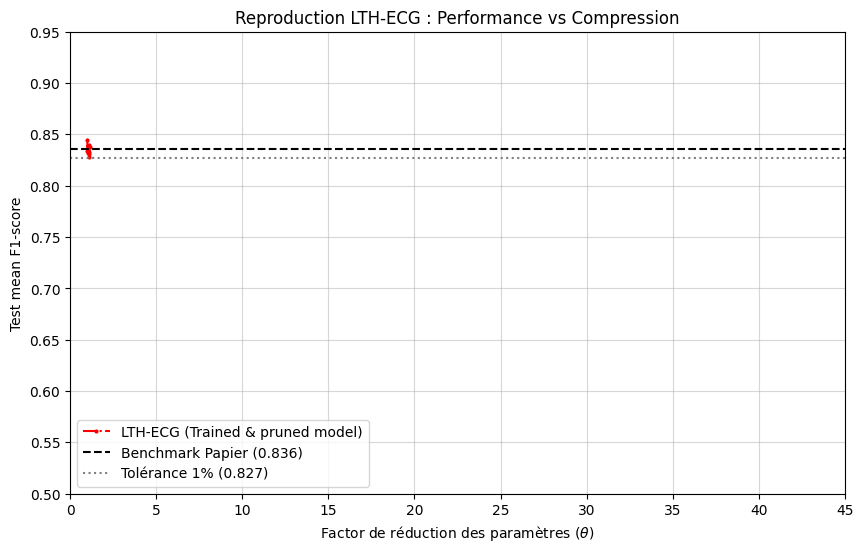

Graphique mis à jour et sauvegardé dans : plots/iterative_pruning_weight_rewinding_True/lth_performance_plot.png


In [15]:
final_mask, history_theta, history_f1 = iterative_pruning(pruning_params, model, train_loader, val_loader, loss_func) 

In [ ]:
# ajouter le nombre de MB que fait le modèle au fur-et-à-mesure, ça se trouve les 1 mb ne sont pas si loin